# Лабораторная работа №2
**Вариант 6.** Ковариационная функция
$$
K(\tau)=D e^{-\alpha|\tau|}(1 + \alpha|\tau|), D=2; \alpha=0.5
$$

Спектральная плотность
$$
S(\omega)=\dfrac{D}{\pi}\dfrac{2\alpha^3}{(\alpha^2+\omega^2)^2}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

## Задание 1. Моделирование методом скользящего среднего
Смоделировать 10 реализации случайного процесса ξ(t) с заданной ковариационной функцией Kξ (τ) и нулевым математическим ожиданием, используя метод скользящего среднего.

In [3]:
# Параметры согласно варианту
D = 2.0
alpha = 0.5

def K_theoretical(tau):
    """Теоретическая ковариационная функция K(tau)."""
    return D * np.exp(-alpha * np.abs(tau)) * (1 + alpha * np.abs(tau))

In [4]:
Tmax = 100.0               
n = 401                    
dt = 2 * Tmax / (n - 1)
t = np.linspace(-Tmax, Tmax, n)

In [5]:
t.shape

(401,)

In [6]:
K_vals = K_theoretical(t)

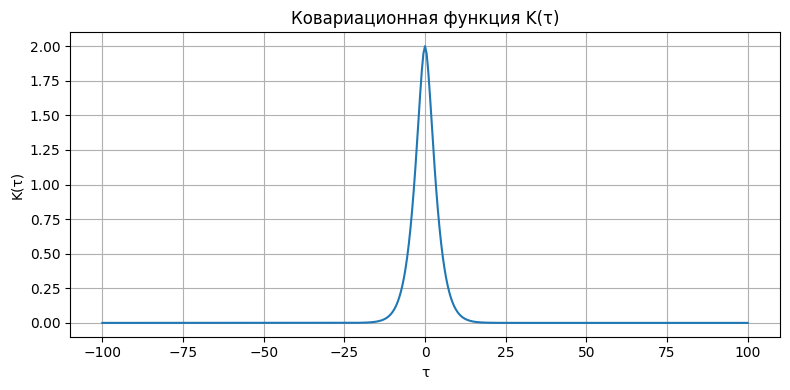

In [7]:
plt.figure(figsize=(8,4))
plt.plot(t, K_vals)
plt.title('Ковариационная функция K(τ)')
plt.xlabel('τ')
plt.ylabel('K(τ)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
N = 51  # число коэффициентов фильтра
lags = np.arange(0, N) * dt
K_lags = K_theoretical(lags)

def residuals(c, K_target):
    """Остатки для системы нелинейных уравнений."""
    Nloc = len(c)
    res = np.zeros(Nloc)
    for m in range(Nloc):
        res[m] = np.dot(c[:Nloc - m], c[m:]) - K_target[m]
    return res

In [9]:
c0 = np.sqrt(K_lags[0]) / np.sqrt(N) * np.ones(N)

# Решаем систему методом наименьших квадратов
sol = least_squares(residuals, c0, args=(K_lags,), xtol=1e-12, ftol=1e-12)
c_est = sol.x

print("Первые 10 коэффициентов системы нелинейных уравнений:", np.round(c_est[:10], 4))

Первые 10 коэффициентов системы нелинейных уравнений: [ 0.0051  0.0129  0.0214  0.0219  0.0047 -0.0261 -0.0552 -0.0592 -0.0202
  0.0471]


In [10]:
# моделирование реализаций методом скользящего среднего
np.random.seed(42)

n_realizations = 1000
white_size = N + n - 1
realizations = np.zeros((n_realizations, n))

for r in range(n_realizations):
    # Генерируем белый шум
    white = np.random.normal(0, 1, white_size)
    x = np.convolve(white, c_est, mode='valid')[:n]
    realizations[r] = x

In [11]:
realizations.shape

(1000, 401)

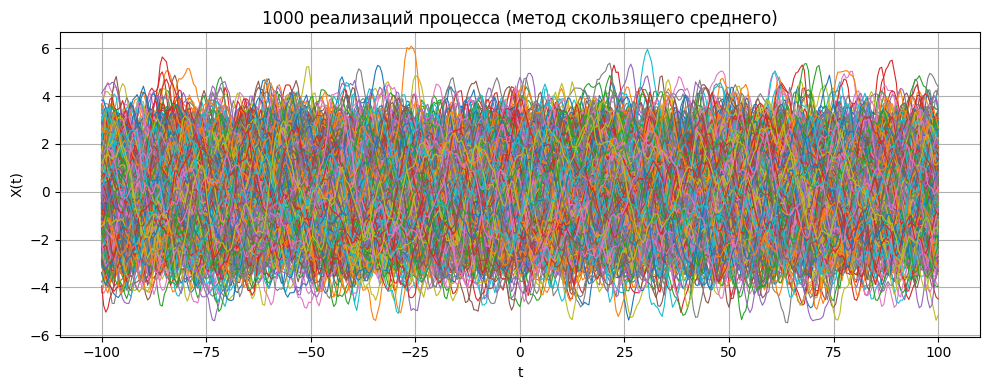

In [12]:
# визуализируем 10 реализаций процесса
plt.figure(figsize=(10,4))
for r in range(n_realizations):
    plt.plot(np.linspace(-Tmax, Tmax, n), realizations[r], linewidth=0.8)
plt.title(f'{n_realizations} реализаций процесса (метод скользящего среднего)')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
realizations.shape

(1000, 401)

(801,)


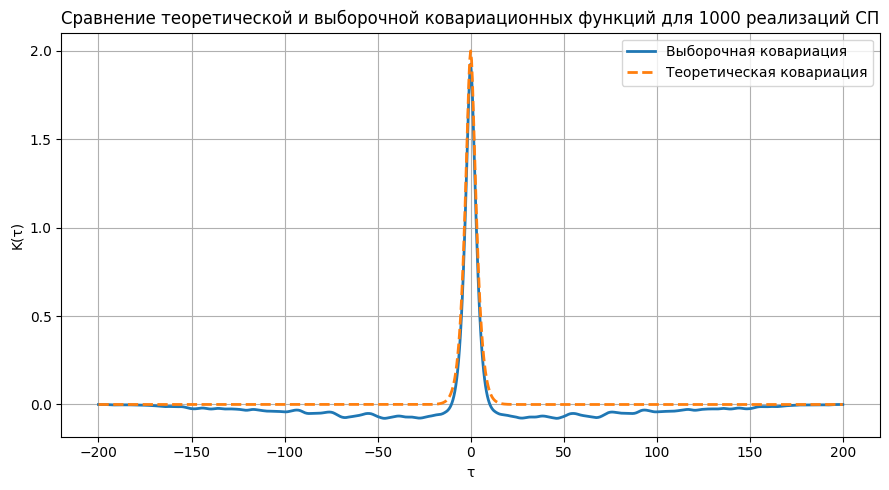

In [15]:
n_realizations, n_time = realizations.shape
dt = t[1] - t[0]

maxlag = n_time - 1
lags = np.arange(-maxlag, maxlag + 1)
tau = lags * dt
print(tau.shape)

K_emp = np.zeros(len(lags))

for r in range(n_realizations):
    x = realizations[r] - realizations[r].mean() 
    corr = np.correlate(x, x, mode='full') / n_time
    K_emp += corr

K_emp /= n_realizations   # усреднение по реализациям

K_theor = K_theoretical(tau)

plt.figure(figsize=(9, 5))
plt.plot(tau, K_emp, label='Выборочная ковариация', linewidth=2)
plt.plot(tau, K_theor, '--', label='Теоретическая ковариация', linewidth=2)
plt.title(f'Сравнение теоретической и выборочной ковариационных функций для {n_realizations} реализаций СП')
plt.xlabel('τ')
plt.ylabel('K(τ)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
print("Среднее по всем реализациям =", realizations.mean())

Среднее по всем реализациям = 0.003328370687422943


In [17]:
from scipy.stats import ttest_1samp

print("Результат одновыборочного t-теста:", ttest_1samp(np.mean(realizations, axis=0), 0.0))

Результат одновыборочного t-теста: TtestResult(statistic=1.3079814887525263, pvalue=0.19163075848802208, df=400)


In [18]:
rmse = np.sqrt(np.mean((K_emp - K_theor)**2))
print("RMSE =", rmse)

RMSE = 0.04760859506200059


## Вывод
- По графику видно, что теоретическая ковариационная функция очень схожа с выборочной. RMSE между выборочной и теоретической ковариационной функциями составляет 0.048;
- Мат. ожидание случайного процесса, полученного методом скользящего среднего, равняется 0.0033, что близко к теоретическому нулевому мат. ожиданию. Однако результат одновыборочного t-теста возвращает p-value, равное 0.19. Таким образом, гипотеза о том, что эмпирическое среднее случайного процесса равно нулю, отвергается.

## Задание 2. Моделирование методом канонического разложения
Смоделировать 10 реализаций стационарного гауссовского случайного процесса с заданной ковариационной функцией Kξ (τ) и нулевым математическим ожиданием.

### Аналитический вывод спектральной плотности по ковариационной функции

Исходная ковариационная функция:
$$
K(\tau) = D e^{-\alpha |\tau|}(1 + \alpha |\tau|)
$$

---

По определению спектральная плотность:
$$
S(\omega) = \frac{1}{2\pi} \int\limits_{-\infty}^{\infty} K(\tau)\,e^{-i\omega\tau}\,d\tau
$$

Так как функция $K(\tau)$ является чётной и симметричной, интеграл можно записать через косинус:
$$
S(\omega) = \frac{1}{\pi} \int\limits_{0}^{\infty} K(\tau)\cos(\omega\tau)\,d\tau
$$

Подставим $K(\tau)$:
$$
S(\omega) = \frac{D}{\pi} \int\limits_{0}^{\infty} e^{-\alpha\tau}(1 + \alpha\tau)\cos(\omega\tau)\,d\tau
$$

---

Обозначим:
$$
I(\omega) = \int\limits_{0}^{\infty} e^{-\alpha\tau}(1 + \alpha\tau)\cos(\omega\tau)\,d\tau
$$

Представим интеграл в виде суммы интегралов:
$$
I(\omega) = \int\limits_{0}^{\infty} e^{-\alpha\tau}\cos(\omega\tau)\,d\tau
+ \alpha \int\limits_{0}^{\infty} \tau e^{-\alpha\tau}\cos(\omega\tau)\,d\tau
$$

---

$$
\int\limits_{0}^{\infty} e^{-a t}\cos(b t)\,dt = \frac{a}{a^2 + b^2}, \quad a > 0
$$

При $a = \alpha,\ b = \omega$:
$$
I_1 = \int\limits_{0}^{\infty} e^{-\alpha\tau}\cos(\omega\tau)\,d\tau
= \frac{\alpha}{\alpha^2 + \omega^2}
$$

---

$$
\int\limits_{0}^{\infty} \tau e^{-a\tau}\cos(b\tau)\,d\tau
= -\frac{d}{da} \left( \frac{a}{a^2 + b^2} \right)
$$

Вычислим производную:
$$
\frac{d}{da} \left( \frac{a}{a^2 + b^2} \right)
= \frac{(a^2 + b^2) - 2a^2}{(a^2 + b^2)^2}
= \frac{b^2 - a^2}{(a^2 + b^2)^2}
$$

Следовательно:
$$
I_2 = \int\limits_{0}^{\infty} \tau e^{-\alpha\tau}\cos(\omega\tau)\,d\tau
= \frac{\alpha^2 - \omega^2}{(\alpha^2 + \omega^2)^2}
$$

---

Объединяем:
$$
I(\omega) = I_1 + \alpha I_2
$$

$$
I(\omega) =
\frac{\alpha}{\alpha^2 + \omega^2}
+ \alpha \cdot \frac{\alpha^2 - \omega^2}{(\alpha^2 + \omega^2)^2}
$$

$$
I(\omega) =
\frac{\alpha(\alpha^2 + \omega^2) + \alpha(\alpha^2 - \omega^2)}
{(\alpha^2 + \omega^2)^2}
$$

$$
I(\omega) = \frac{2\alpha^3}{(\alpha^2 + \omega^2)^2}
$$

---

Подставляем $I(\omega)$:
$$
S(\omega) = \frac{D}{\pi} \cdot \frac{2\alpha^3}{(\alpha^2 + \omega^2)^2}
$$

---
**Вывод**


Таким образом, результат аналитического расчета спектральной плотности случайного процесса совпадает с изначально заданным для 6-го варианта выражением

In [19]:
def S_theoretical(omega):
    """Аналитическая спектральная плотность S(omega)."""
    return (D / np.pi) * (2 * alpha**3) / (alpha**2 + omega**2)**2

print("K(0) =", K_theoretical(0.0))
print("S(0) =", S_theoretical(0.0))

K(0) = 2.0
S(0) = 2.5464790894703255


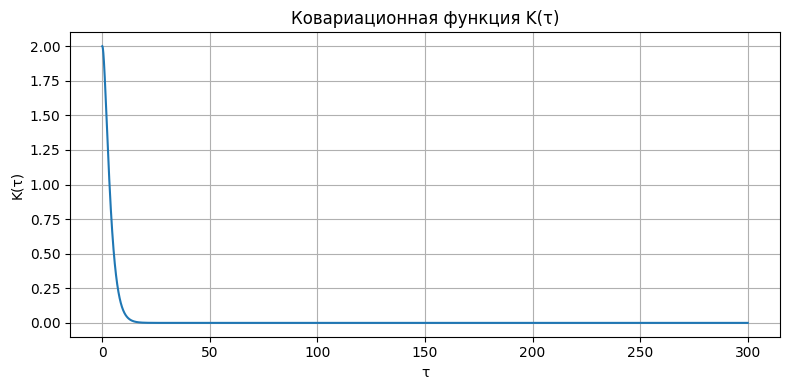

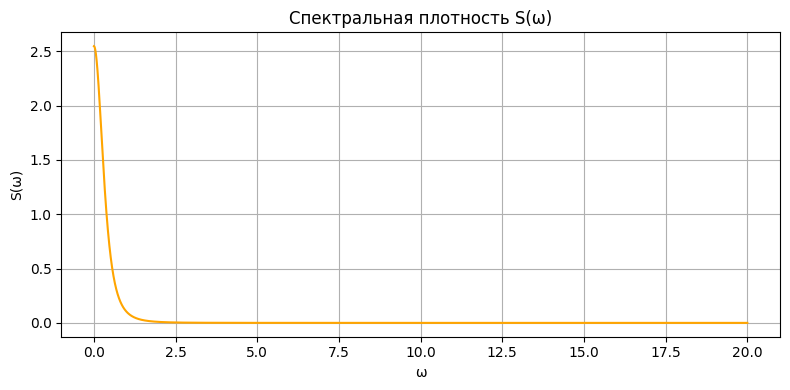

In [20]:
tau_grid = np.linspace(0, 300, 20001)  # диапазон τ для графика
K_grid = K_theoretical(tau_grid)

plt.figure(figsize=(8,4))
plt.plot(tau_grid, K_grid, label='K(τ)')
plt.title('Ковариационная функция K(τ)')
plt.xlabel('τ')
plt.ylabel('K(τ)')
plt.grid(True)
plt.tight_layout()
plt.show()

omega_grid = np.linspace(0, 20, 10001)
S_grid = S_theoretical(omega_grid)

plt.figure(figsize=(8,4))
plt.plot(omega_grid, S_grid, label='S(ω)', color='orange')
plt.title('Спектральная плотность S(ω)')
plt.xlabel('ω')
plt.ylabel('S(ω)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
T_p = 100      
omega_B = 2.5  

M = int(np.floor(omega_B * T_p / (2 * np.pi)))
omega_k_pos = np.arange(1, M + 1) * np.pi * 2 / T_p

n_time = 401
t = np.linspace(-T_p, T_p, n_time)
dt = t[1] - t[0]

print(f"T_p = {T_p}, ω_B = {omega_B}")
print(f"ω = {np.pi * 2 / T_p:.4f}, M (нечетное) = {M}")
print(f"Временной шаг dt = {dt:.4f}, число точек = {n_time}")

T_p = 100, ω_B = 2.5
ω = 0.0628, M (нечетное) = 39
Временной шаг dt = 0.5000, число точек = 401


In [40]:
Delta_omega = np.pi / T_p
S_k = S_theoretical(omega_k_pos)
Dk = S_k * Delta_omega  
print(f"{M} дисперсий гармоник:", np.round(Dk, 6))

39 дисперсий гармоник: [0.077532 0.070776 0.061329 0.050983 0.041122 0.032518 0.025427 0.019789
 0.015401 0.012027 0.009442 0.007464 0.005944 0.00477  0.003859 0.003146
 0.002584 0.002138 0.001782 0.001494 0.001261 0.001071 0.000914 0.000785
 0.000677 0.000587 0.000511 0.000447 0.000392 0.000346 0.000306 0.000271
 0.000242 0.000216 0.000193 0.000174 0.000156 0.000141 0.000128]


In [45]:
np.random.seed(0)
n_realizations = 1000

sigma_coeff = np.sqrt(Dk / 2.0)   # стандартные отклонения для u_k и v_k

realizations = np.zeros((n_realizations, n_time))

for r in range(n_realizations):
    u_k = np.random.normal(loc=0.0, scale=sigma_coeff, size=len(omega_k_pos))
    v_k = np.random.normal(loc=0.0, scale=sigma_coeff, size=len(omega_k_pos))
    X = np.zeros_like(t)
    for k_idx, w in enumerate(omega_k_pos):
        X += u_k[k_idx] * np.cos(w * t) + v_k[k_idx] * np.sin(w * t)
    realizations[r, :] = X

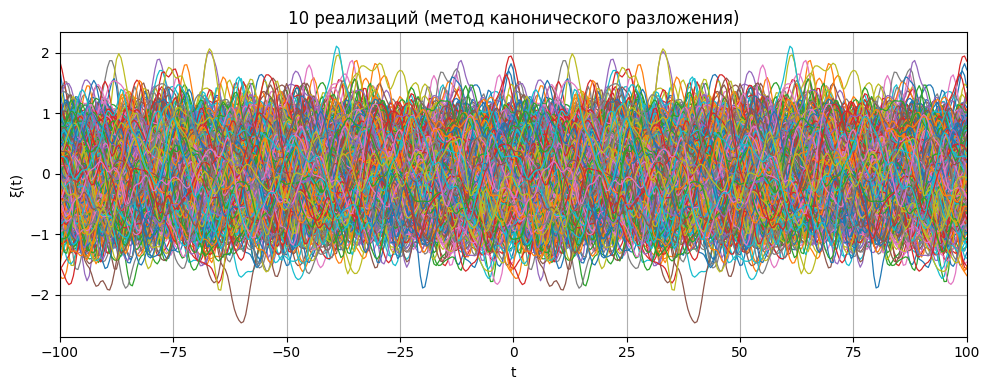

In [46]:
plt.figure(figsize=(10,4))
for r in range(n_realizations):
    plt.plot(t, realizations[r], linewidth=0.9)
plt.xlim(-T_p, T_p)
plt.xlabel('t')
plt.ylabel('ξ(t)')
plt.title('10 реализаций (метод канонического разложения)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
variance_total = K_theoretical(0.0)
variance_accounted = 2 * np.sum(Dk)
method_error_abs = variance_total - variance_accounted
method_error_rel = method_error_abs / variance_total
print("Дисперсия (теоретическая) =", variance_total)
print("Дисперсия, учтенная гармониками ≈", variance_accounted)
print("Абсолютная погрешность =", method_error_abs)
print("Относительная погрешность =", method_error_rel)

Дисперсия (теоретическая) = 2.0
Дисперсия, учтенная гармониками ≈ 0.9166926447632162
Абсолютная погрешность = 1.0833073552367838
Относительная погрешность = 0.5416536776183919


Выборочное среднее (в среднем по времени) = -0.0000165


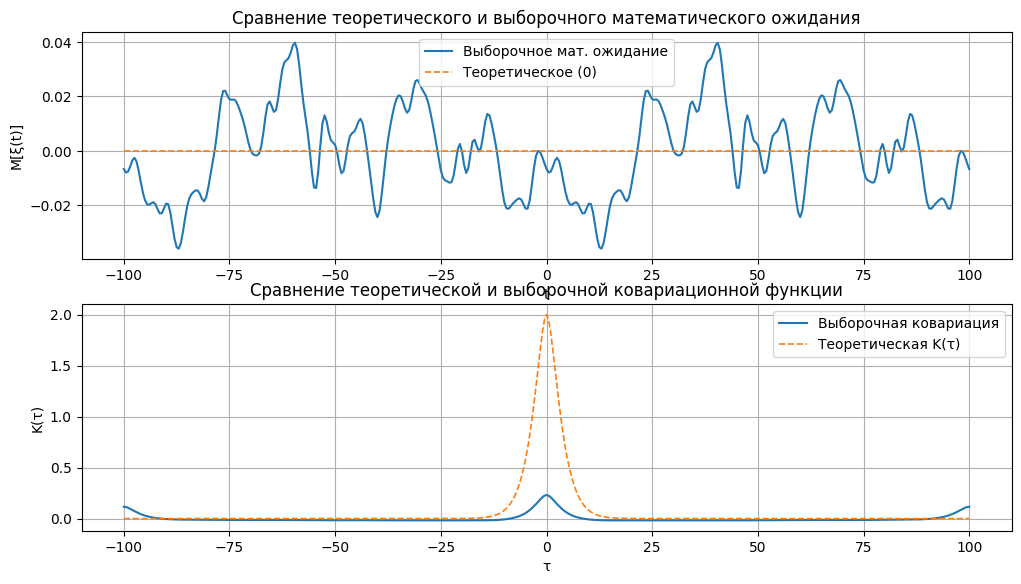

In [49]:
sample_mean = np.mean(realizations, axis=0)
theoretical_mean = np.zeros_like(t)

maxlag = int(0.5 * len(t))
lags_idx = np.arange(-maxlag, maxlag + 1)
acov = np.zeros_like(lags_idx, dtype=float)

for r in range(n_realizations):
    x = realizations[r] - realizations[r].mean()
    acorr = np.correlate(x, x, mode='full') / len(x)
    center = len(acorr)//2
    acov += acorr[center - maxlag: center + maxlag + 1]
acov /= n_realizations

tau_lags = lags_idx * (t[1] - t[0])

K_theor_lags = K_theoretical(tau_lags)

mean_emp = np.mean(sample_mean)
var_emp = np.var(realizations, ddof=1)
print(f"Выборочное среднее (в среднем по времени) = {mean_emp:.7f}")
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(t, sample_mean, label='Выборочное мат. ожидание', linewidth=1.5)
plt.plot(t, theoretical_mean, '--', label='Теоретическое (0)', linewidth=1.2)
plt.title('Сравнение теоретического и выборочного математического ожидания')
plt.xlabel('t')
plt.ylabel('M[ξ(t)]')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tau_lags, acov, label='Выборочная ковариация', linewidth=1.5)
plt.plot(tau_lags, K_theor_lags, '--', label='Теоретическая K(τ)', linewidth=1.2)
plt.title('Сравнение теоретической и выборочной ковариационной функции')
plt.xlabel('τ')
plt.ylabel('K(τ)')
plt.legend()
plt.grid(True)
plt.show()
